# Mapping and Prediction of Incised Features.

## Imports

In [1]:
#from jupyterthemes import jtplot
#jtplot.style()
import numpy as np
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from landlab.plot.imshow import imshow_grid 
# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator, FlowRouter, LakeMapperBarnes, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure


In [2]:
level_of_generalisation = 6
location = (r'C:/PhD/junk')
os.chdir(location)
input_geotiff = gdal.Open('aranda.tif')
initial_resolution = 1
x = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
input_DEM = x
kernel = np.loadtxt('kernel.txt')
kernel_1d = np.reshape(kernel,(1,121))

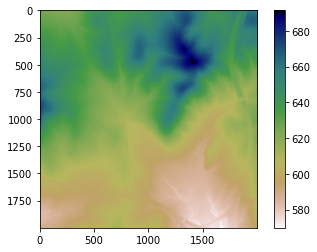

In [3]:
plt.imshow(input_DEM, cmap="gist_earth_r")
plt.colorbar()

## Define functions

In [56]:
def surf_plot(mg, surface='topographic__elevation', 
              title='Surface plot of topography', colormap = cm.gray):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = (mg.at_node[surface].reshape(mg.shape))#[y1:y2, x1:x2]
    color = colormap((Z-Z.min())/(Z.max()-Z.min()))
    surf = ax.plot_surface(mg.node_x.reshape(mg.shape),#[y1:y2, x1:x2]
                           mg.node_y.reshape(mg.shape),#[y1:y2, x1:x2]
                           Z,
                           rstride=1, cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False)
    ax.view_init(elev=35, azim=-120)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()

def x_y_size_test(input_array, resolution_ratio, resample_levels, number_of_options):
    """This function checks the size of the array and ensures that it can be resampled up and down 
    by a factor of three and always result in an array of the original size."""
    # Check number of rows and columns. 
    rows = np.size(input_array, 0)
    columns = np.size(input_array, 1)
    array_sizes = []
    for i in range(1,number_of_options):
        min_dim_size = resolution_ratio ** resample_levels
        ideal_array = i * min_dim_size
        array_sizes.append(ideal_array)
    ideal_row = next(x[1] for x in enumerate(array_sizes) if x[1] > rows)
    ideal_col = next(x[1] for x in enumerate(array_sizes) if x[1] > columns)
    add_rows = ideal_row - rows
    add_columns = ideal_col - columns
    # Create an empty array to the pad if required.
    empty_array = np.zeros((rows + add_rows, columns + add_columns))     
    offset_rows = int(-1 * add_rows)
    offset_columns = int(-1 * add_columns)
    empty_array[:offset_rows, :offset_columns] = input_array
    return empty_array

def resample_resolution_lower(data, ratio):
    """Takes some gridded data and a desired resampling ratio. For example, a resolution ratio 
       of 3 means that for data of a base resolution == 25m, one step up in resolution would be 75m
       and one step up from that would be 225m etc""" 
    zoom_factor = Fraction(1,3 ** ratio)
    # Order one is bilinear interpolation.
    resample = scipy.ndimage.zoom(data, zoom_factor, order = 1)
    return resample

def resample_resolution_higher(data, ratio):
    """Takes some gridded data and a desired resampling ratio. For example, a resolution ratio 
       of 3 means that for data of a base resolution == 25m, one step up in resolution would be 75m
       and one step up from that would be 225m etc""" 
    zoom_factor = 3 ** ratio
    # Order one is bilinear interpolation.
    resample = scipy.ndimage.zoom(data, zoom_factor, order = 1)
    return resample

def rectangleWindow(m, n):
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    rectangle = np.ones((m, n), dtype=bool) 
    return rectangle

def number_of_values(Window):
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
    denominator = sum(sum(Window > 0))
    return denominator

def slopeWindow(DEM_slope, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM_slope[0]; b = DEM_slope[1]; c = DEM_slope[2]
    d = DEM_slope[3]; e = DEM_slope[4]; f = DEM_slope[5]
    g = DEM_slope[6]; h = DEM_slope[7]; i = DEM_slope[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but askinh for both causes it to throw and error.
    return slope_percent

def slopeWindowDegrees(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_degrees

def planCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
    systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    plan_curvature = (2 * (D*(H**2) + E*(G**2) - (F*G*H))) / (G**2 + H**2)
    return plan_curvature

def profileCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    profile_curvature = (-2 * (D*(G**2) + E*(H**2) + (F*G*H))) / (G**2 + H**2)
    return profile_curvature

def circleWindow(radius):
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle

def find_median_value(Window):
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer."""
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value

def DFME(elev):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = elev[central_value]                        
    mean = np.nanmean(elev)#Count number of values greater than centroid value
    diff = centroid - mean
    return diff

def valleys(local_dem, resolution, top, bottom, left, right):
    """Function to remove noise present in non-valley positions."""
    working_dem = np.copy(local_dem[top:bottom, left:right])
    av = np.nanmean(working_dem)
    st = np.nanstd(working_dem)
    limit = av + st
    working_dem[working_dem  > limit] = limit
    max_h = np.nanmax(working_dem)
    valleys = np.divide(working_dem, max_h)
    a = np.nanmin(valleys)
    b = np.nanmax(valleys)
    c = math.log(resolution, 3)
    intp = (1/(b - a))*(valleys - a)
    f_of_t = c + (1 - (1/(b - a))*(valleys - a))
    return f_of_t

def PCTL(x):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = x[central_value]                        
    y = np.sum(x < centroid)/num_values#Count number of values greater than centroid value
    return y

def map_to_sinewave(data, center, boundary):
    distance = np.maximum(center - np.sqrt((data - center)**2), boundary)
    mapped_values = 1 - np.sin(np.pi + (10*(distance - center)*(np.pi /6)))
    return mapped_values

def Nxtp(x, t, p):
    """Takes a DEM derivative (x, such as slope or elevation percentile 
       and maps it onto the range [0,1] using a non-linear equation with a shape 
       parameter (t) and a threshold parameter (p)"""
    standardise_value = 1/(1+(x/t)**p)
    print (x)
    print (t)
    print (p)
    return standardise_value

def scale_limit(scale):
    """Assesses relative representation of each component at different scales.
    The variable 'scale' refers to the scale of the input data with 1 == 1m, 2 == 3m etc."""
    vf = resample_resolution_higher(array_ILE['VF_ILE' + str(scale) + str(scale)][0], scale - 1)  
    ff = resample_resolution_higher(array_ILE['FF_ILE' + str(scale) + str(scale)][0], scale - 1)   
    fw = resample_resolution_higher(array_ILE['FW_ILE' + str(scale) + str(scale)][0], scale - 1)   
    fe = resample_resolution_higher(array_ILE['FE_ILE' + str(scale) + str(scale)][0], scale - 1) 
    
    c1 = np.maximum(ff, fe)
    c2 = np.maximum(c1, fw)
    c3 = np.maximum(c2, vf)

    filtered_ILEs = median_filter(c3, size = 7, mode = 'nearest')
    filtered_ILEs[filtered_ILEs > 0.5] = 1
    filtered_ILEs[filtered_ILEs < 0.5] = 0
    
    filtered_vf = vf * filtered_ILEs
    filtered_ff = ff * filtered_ILEs
    filtered_fw = fw * filtered_ILEs
    filtered_fe = fe * filtered_ILEs
    
    vf_ratio = np.sum(filtered_vf[300:-300, 300:-300] > 0.5)
    ff_ratio = np.sum(filtered_ff[300:-300, 300:-300]  > 0.5)
    fe_ratio = np.sum(filtered_fe[300:-300, 300:-300]  > 0.5)
    fw_ratio = np.sum(filtered_fw[300:-300, 300:-300]  > 0.5)
    
    ratios = vf_ratio + ff_ratio + fe_ratio + fw_ratio
    
    vf_percent = 100 / ratios * vf_ratio
    ff_percent = 100 / ratios * ff_ratio
    fe_percent = 100 / ratios * fe_ratio
    fw_percent = 100 / ratios * fw_ratio

    return vf_percent, ff_percent, fw_percent, fe_percent

def TWI(slope, As):
    """Calculates Topographic Wetness Index (TWI) taking a slope layer in degrees,
    the catchment area of the cell calculated using a chosen flow routing algorithm and 
    the cell resolution of the slope and catchment area layers input as an integer."""
    tolerance = 1e-16
    slope_radians = np.deg2rad(slope)
    tanB = np.tan(slope_radians)
    tanB[tanB < tolerance] = tolerance
    sca = np.asarray(As)
    sca[sca < tolerance] = tolerance
    W = np.log(np.divide(sca, tanB))
    TWI = np.asarray(W)
    TWI[TWI < tolerance] = 0
    return TWI

def SPI(slope, As):
    """Calculates Compound Topographic Index (TWI) taking a slope layer in degrees and
    the catchment area of the cell calculated using a chosen flow routing algorithm."""
    tolerance = 1e-16
    slope_radians = np.deg2rad(slope)
    tanB = np.tan(slope_radians)
    tanB[tanB < tolerance] = tolerance
    C = np.multiply(As, tanB)
    C_N = np.nan_to_num(C)
    return C_N
    
def TWI_D8(slope, area, cell_resolution):
    """Calculates Topographic Wetness Index (TWI) taking a slope layer in degrees,
    the catchment area of the cell calculated using a chosen flow routing algorithm and 
    the cell resolution of the slope and catchment area layers input as an integer."""
    As = np.divide(area, cell_resolution)
    slope_radians = np.deg2rad(slope)
    tanB = np.tan(slope_radians)
    W = np.log(np.divide(As, tanB))
    W_N = np.nan_to_num(W)
    return W_N

def SPI_D8(slope, area, cell_resolution):
    """Calculates Compound Topographic Index (TWI) taking a slope layer in degrees and
    the catchment area of the cell calculated using a chosen flow routing algorithm."""
    As = np.divide(area, cell_resolution)
    slope_radians = np.deg2rad(slope)
    tanB = np.tan(slope_radians)
    tanB[tanB < tolerance] = tolerance
    C = np.multiply(As, tanB)
    C_N = np.nan_to_num(C)
    return C_N

def gaussian_filter(image, kernel):
    """This function applies a gaussian smoothing filter to the data. It takes an input DEM
    and kernel file (read in as a numpy array). This is the exact same filter used by MRVBF"""
    convolution = np.mean(np.multiply(kernel, image))
    return convolution

def find_matching_level(L):
    find_divisor_integer = L//2
    find_remainder = L%2
    matching_generalisation_level = find_divisor_integer + find_remainder
    matching_cell_resolution = matching_generalisation_level - find_remainder
    return matching_generalisation_level, matching_cell_resolution

def flow_dir_dataset(flow_rec_prop, catchment_area, generalisation_Lm1):
    """ Create an xarray Dataset containing eight arrays each representing the
    amount of water flowing in the given direction. 
    
        1 . flow_rec_prop == the flow receiver proportion array created by LandLab flow routing.
        2 . catchment_area == the corresponding catchment area array from the landLab flow accumulation.
        surface.
        3. generalisation_Lm1 is simply used to resample all array to have equal dimensions prior
        to being combined so that they can all be pushed into an xarray Dataset.
        
    The resulting Dataset is used to calculate specific catchment area."""
    
    array_direction = xr.Dataset()
    
    for i in range(0,8):
        shell_array = np.copy(catchment_area)
        direction = flow_rec_prop[:,i]
        reshape_direction = direction.reshape(rows,cols)
        direction_array = np.flip(reshape_direction, 0)
        shell_array[0:rows, 0:cols] = direction_array
        shell_array_resample = resample_resolution_higher(shell_array, generalisation_Lm1 - 1)
        catchment_area_resample = resample_resolution_higher(catchment_area, generalisation_Lm1 - 1)
        weighted_direction = xr.DataArray((catchment_area_resample * shell_array_resample),
                                          dims = ['lat', 'lon'])
        array_direction[direction_list[i]] = weighted_direction
        
    E, N, W, S, NE, NW, SW, SE = (array_direction['East'], array_direction['North'],
                             array_direction['West'], array_direction['South'],
                             array_direction['North East'], array_direction['North West'],
                             array_direction['South West'], array_direction['South East'])

    flow_dirs = xr.concat([E, N, W, S, NE, NW, SW, SE], 'direction')
    flow_dirs.name = 'flow_directions'
    resolution = 3**(generalisation_Lm1 - 1)
    flow_dirs.attrs['grid cell resolution'] = resolution
    flow_directions = flow_dirs.assign_coords(direction=(['East','North','West','South',
                                   'North East', 'North West','South West', 'South East']))
    return flow_directions

def specific_catchment_area(dir_list):
    
    spca_Dataset = xr.Dataset()

    dir_dicts = [{'Direction': 'East', 'x1': 1, 'x2': -1, 'y1': 2, 'y2': None}, 
                    {'Direction': 'North','x1': None, 'x2': -2, 'y1': 1, 'y2': -1},
                    {'Direction': 'West' , 'x1': 1, 'x2': -1, 'y1': None, 'y2': -2},
                    {'Direction': 'South' , 'x1': 2, 'x2': None, 'y1': 1, 'y2': -1},
                    {'Direction': 'North East' , 'x1': None, 'x2': -2, 'y1': 2, 'y2': None},
                    {'Direction': 'North West' , 'x1': None, 'x2': -2, 'y1': None, 'y2': -2},
                    {'Direction': 'South West' , 'x1': 2, 'x2': None, 'y1': None, 'y2': -2},
                    {'Direction': 'South East', 'x1': 2, 'x2': None, 'y1': 2, 'y2': None}]

    for varname, ds in dir_arrays_all_scales.data_vars.items():
        loop_temp_ds = xr.Dataset()
        for i in range(0,8):
                buffer = ds.sel(direction = dir_list[i]);
                resolution = buffer.attrs['grid cell resolution'];
                if i < 4:
                    flow_width = resolution;
                else: 
                    flow_width = math.sqrt(2) * resolution;
                    
                resample_factor = math.log(resolution, 3);
                buffer_r = resample_resolution_lower(buffer, int(resample_factor));
                lat = buffer_r.shape[0]; lon = buffer_r.shape[1];
                exp = np.zeros((lat + 2,lon + 2));
                exp[dir_dicts[i]['x1']:dir_dicts[i]['x2'],
                        dir_dicts[i]['y1']:dir_dicts[i]['y2']] = np.divide(buffer_r, flow_width);
                spca_shell = exp [1:-1,1:-1];
                spca = xr.DataArray(resample_resolution_higher(spca_shell, int(resample_factor)),
                                              dims = ['lat', 'lon']);
                loop_temp_ds[dir_list[i]] = spca
                
        E, N, W, S, NE, NW, SW, SE = (loop_temp_ds['East'], loop_temp_ds['North'],
                                loop_temp_ds['West'], loop_temp_ds['South'],
                                loop_temp_ds['North East'], loop_temp_ds['North West'],
                                loop_temp_ds['South West'], loop_temp_ds['South East'])

        spca_dirs = xr.concat([E, N, W, S, NE, NW, SW, SE], 'direction')
        resolution = 3**(int(varname[-2:-1]) - 2)
        
        specific_ca = spca_dirs.sum('direction')
        specific_ca.attrs['grid cell resolution'] = resolution
        spca_Dataset['spca' + '_' + varname] = specific_ca
        
    return spca_Dataset

def prep_model_grid(original_dem, generalisation_Lm1):
    """This function is used to take a subset of the current workign DEM equal in size to the 
    maximum possible given the resolution of the current processing step. It assesses by how many 
    rows and columns the input DEM needs to be decreased by in order to be perfectly divisible
    by the resolution of the current processing step."""
    divide_by = 3**(int(generalisation_Lm1) - 1)
    nibble_by = original_dem.shape[0] % divide_by
    DEM_subset = np.copy(original_dem)
    if nibble_by == 0:
        return original_dem
    else:
        topo_surface = DEM_subset[0:-nibble_by, 0:-nibble_by]
        return topo_surface


## Prepare DEM for processing

In [5]:
minimum = np.amin(input_DEM)
mask_template = np.copy(input_DEM)
mask_template[mask_template != minimum] = 1
mask_template[mask_template == minimum] = np.nan
mask = x_y_size_test(mask_template, 3, 5, 100)

DEM = x_y_size_test(input_DEM, 3, 5, 100)
DEM[DEM < minimum] = minimum

## Create grids of catchment area for all scales

In [6]:
array_DEM = {}
DEM11 = np.copy(DEM)
array_DEM.setdefault('DEM'+ '1' + '1', []).append(DEM11);
DEM21 = median_filter(DEM, size = 7, mode = 'nearest')
array_DEM.setdefault('DEM'+ '2' + '1', []).append(DEM21);
DEM22 = resample_resolution_lower(DEM21, 1);
array_DEM.setdefault('DEM'+ '2' + '2', []).append(DEM22);
#################################################################################################
#These determine scale at which flow accumulation is being conducted where the processed 
# grid is always a smoothed version of the DEM (DEML_Lm1) and resolution is equal to 
# 3^(i - 1). For example, a flow scale equal to 2 would have a resolution of 3m. 
min_flow_scale = 2
max_flow_scale = 7
#################################################################################################
# Create an xarray Dataset to contain all flow direction DataArrays at each scale of processing.
dir_arrays_all_scales = xr.Dataset()
# This is the direction order that LandLab routes flow.
direction_list = ['East', 'North', 'West', 'South',
                  'North East', 'North West', 'South West', 'South East'];
#################################################################################################
for i in range(min_flow_scale, max_flow_scale):
    L = str(i); 
    Lm1 = str(i - 1);
    DEML_Lm1 = median_filter(array_DEM['DEM'+ Lm1 + Lm1][0], size = 7, mode = 'nearest');
    array_DEM.setdefault('DEM'+ L + Lm1, []).append(DEML_Lm1);
    DEML_L = resample_resolution_lower(DEML_Lm1, 1);
    array_DEM.setdefault('DEM'+ L + L, []).append(DEML_L);
    flow_acc_surf = np.copy(DEML_Lm1);
    resolution_step_L = 3**(int(L) - 2);
    print(resolution_step_L);
    #################################################################################################
    # Ensuring the DEM has the correct properties to work within the model grid 
    # structure of LandLab.
    flow_subset = prep_model_grid(input_DEM, Lm1).astype('float64');
    #################################################################################################
    # Determine size of subset DEM by dividing each axis by the resolution of
    # the current processing step.
    rows = int(flow_subset.shape[0] / resolution_step_L);
    cols = int(flow_subset.shape[1] / resolution_step_L) ;   
    # Extract the designated subset from the current working DEM.
    input_surface = flow_acc_surf[0:rows, 0:cols];
    #The output is now fed into a RasterModelGrid to process flow accumulation.
    mg = RasterModelGrid((rows,cols), spacing=(resolution_step_L, resolution_step_L));
    mg.add_field('topographic__elevation', input_surface, at = 'node');
    sfb = SinkFillerBarnes(mg, method = 'Steepest', ignore_overfill = True);
    sfb.run_one_step();
    fa = FlowAccumulator(mg,
                        surface = 'topographic__elevation',
                        flow_director = 'FlowDirectorMFD',
                        diagonal = True);
    (flow_acc, q) = fa.accumulate_flow();
    si = np.array(mg.at_node['flow__sink_flag']);
    sr = si.reshape(rows,cols);
    da = np.array(mg.at_node['drainage_area']);
    dr = da.reshape(rows,cols);
    # Insert the flow accumulation subset back into DEM that the subset was taken from
    # and append to dictionary.
    flow_acc_surf[0:rows, 0:cols] = dr;
    sink_surf = np.copy(flow_acc_surf);
    sink_surf[0:rows, 0:cols] = sr;
    array_DEM.setdefault('CA'+ L + Lm1, []).append(flow_acc_surf);
    array_DEM.setdefault('SI'+ L + Lm1, []).append(sink_surf);
    fd = FlowDirectorMFD(mg, 'topographic__elevation', diagonals = True);
    fd.direct_flow();
    frp = np.array(mg.at_node['flow__receiver_proportions']);
    flow_rec_surf_rows = cols * rows;
    rp = frp.reshape(flow_rec_surf_rows,8);
    flow_rec_surf = np.zeros((flow_rec_surf_rows,8));
    flow_rec_surf[0:flow_rec_surf_rows, 0:8] = rp;
    array_DEM.setdefault('FRP'+ L + Lm1, []).append(flow_rec_surf);
    all_receiver_proportions = np.copy(array_DEM['FRP'+ L + Lm1][0]); 
    CA = array_DEM['CA'+ L + Lm1][0];
    flow_dir_da = flow_dir_dataset(all_receiver_proportions, CA, int(Lm1));
    dir_arrays_all_scales['dir_arr' + L + '1'] = flow_dir_da;


1
3
9
27
81


In [9]:
%%capture
specific_catchment_areas = specific_catchment_area(direction_list)
specific_catchment_dict = {}
for varname, ds in specific_catchment_areas.data_vars.items():
    As = np.array(ds[:, :])
    specific_catchment_dict.setdefault(varname, []).append(As);

array_LL = {}
range_min = 1
range_max = level_of_generalisation
lowness_index = [0.40, 0.45, 0.50, 0.55, 60]
for i in range(range_min, range_max):
    radius = 6
    central_value = find_median_value(circleWindow(radius))
    num_values = number_of_values(circleWindow(radius))
    step_L = i
    L = str(step_L)
    print(step_L)
    Lm1 = str(int(step_L) - 1)
    Lp1 = str(int(step_L) + 1)
    DEML_L = np.copy(array_DEM['DEM'+ L + L][0])
    DEMLp1_L = np.copy(array_DEM['DEM'+ Lp1 + L][0])
    PCTLL_L = generic_filter(DEML_L, PCTL, footprint= circleWindow(radius), mode='nearest')
    array_LL.setdefault('PCTL'+ L + L, []).append(PCTLL_L);
    zf = int(L) - 1;
    PCTLL_1 = resample_resolution_higher(PCTLL_L, zf);
    valley_level = lowness_index[i - 1];
    WPCTL2 = Nxtp(PCTLL_1, valley_level, 4);#
    array_LL.setdefault('WPCTL'+ L + L, []).append(WPCTL2);
    IPCTLL_1 = Nxtp(PCTLL_1, valley_level, 4);
    FLL_1 = np.copy(IPCTLL_1);
    array_LL.setdefault('FLL'+ L + '1', []).append(FLL_1);
    slope_resolution = resolution_step_L = 3**(int(L) - 1); 
    slope_degree = generic_filter(DEMLp1_L, slopeWindowDegrees,
                      footprint= rectangleWindow(3,3),
                      mode='constant', extra_arguments = (slope_resolution,slope_resolution,));
    slope_base_r = resample_resolution_higher(slope_degree, zf);
    array_LL.setdefault('slope_degrees'+ L + '1', []).append(slope_base_r);
    select_specific_catchment_area = 'spca_dir_arr' + str(Lp1) + '1'
    twi_spi_spca = specific_catchment_dict[select_specific_catchment_area][0];
    topographic_wetness_index = TWI(slope_base_r, twi_spi_spca);
    array_LL.setdefault('TWI'+ L + '1', []).append(topographic_wetness_index);
    TWIL_1 = 1 - Nxtp(topographic_wetness_index, 6.8, 4);
    stream_power_index = SPI(slope_base_r, twi_spi_spca);
    array_LL.setdefault('SPI'+ L + '1', []).append(stream_power_index);
    CTIL_1 = 1 - Nxtp(stream_power_index, 18, 4);
    TIL_1 = 1 - Nxtp(TWIL_1 * CTIL_1, 0.25, 4);
    WTIL_1 = 1 - Nxtp(TIL_1, 0.4, 6.68);
    array_LL.setdefault('TIL'+ L + '1', []).append(TIL_1);
    array_LL.setdefault('CTIL'+ L + '1', []).append(CTIL_1);
    array_LL.setdefault('TWIL'+ L + '1', []).append(TWIL_1);
    PFLL_1 = 1 - Nxtp((IPCTLL_1 + TIL_1)/2.0, 0.25, 4);
    array_LL.setdefault('PFLL'+ L + '1', []).append(PFLL_1);

#############################################################################################

FFL51 = np.copy(array_LL['FLL51'][0]) # This is different because it is not using topographic indices.
PFL41 = np.copy(array_LL['PFLL41'][0])
PFL31 = np.copy(array_LL['PFLL31'][0])
PFL21 = np.copy(array_LL['PFLL21'][0])
PFL11 = np.copy(array_LL['PFLL11'][0])

WL_1 = 1 - Nxtp(PFL41, 0.5, 6.68);
areas_at_risk_l1 = WL_1 * (1 + PFL41) + (1 - WL_1)*FFL51
pl = (math.log((2 - 0.5)/0.1)) / math.log(1.5)
WL_2 = 1 - Nxtp(PFL31, 0.5, pl)
areas_at_risk_l2 = (WL_2 * (2 + PFL31)) + ((1 - WL_2) * areas_at_risk_l1)
pl = (math.log((3 - 0.5)/0.1)) / math.log(1.5)
WL_3 = 1 - Nxtp(PFL21, 0.5, pl)
areas_at_risk_l3 = (WL_3 * (3 + PFL21)) + ((1 - WL_3) * areas_at_risk_l2)
pl = (math.log((4 - 0.5)/0.1)) / math.log(1.5)
WL_4 = 1 - Nxtp(PFL11, 0.5, pl)
areas_at_risk = (WL_4 * (4 + PFL11)) + ((1 - WL_4) * areas_at_risk_l3)

#############################################################################################
#Slope positions.
lw_position = 0.2
fw_position = 0.3
fe_position = 0.4

#Parameter thresholds.
flatness_thresholds = {1:['Thresholds', 20, 13.5, 9, 6, 4]};
steepness_thresholds = {1:['Thresholds', 20, 13.5, 9, 6, 4]};
curvature_thresholds = {1:['Thresholds', 0.02, 0.0135, 0.009, 0.006, 0.004]};
#############################################################################################
array_ILE = {}
range_max = level_of_generalisation
for i in range(1,level_of_generalisation):
    step_L = i
    L = str(step_L)
    Lm1 = str(int(step_L) - 1)
    Lp1 = str(int(step_L) + 1)
    slope_resolution = 3**(i - 1);
    DEM_ILE = array_DEM['DEM' + str(i) + str(i)][0];
    SL = generic_filter(DEM_ILE, slopeWindow,
                      footprint= rectangleWindow(3,3),
                      mode='constant', extra_arguments = (slope_resolution,slope_resolution,));
    array_ILE.setdefault('SL'+ L + L, []).append(SL);
    radius = 6
    central_value = find_median_value(circleWindow(radius))
    num_values = number_of_values(circleWindow(radius))
    PCTL_ILE_ends = generic_filter(DEM_ILE, PCTL, footprint= circleWindow(radius), mode='nearest');
    radius = 30
    central_value = find_median_value(circleWindow(radius))
    num_values = number_of_values(circleWindow(radius))
    PCTL_ILE_trunks = generic_filter(DEM_ILE, PCTL, footprint= circleWindow(radius), mode='nearest');
    PCTL_ILE_1 = np.copy(PCTL_ILE_ends);
    PCTL_ILE_2 = np.copy(PCTL_ILE_trunks);
    PCTL_position = np.copy(array_LL['PCTL' + L + L][0]);
    valley_positions = resample_resolution_higher(Nxtp(PCTL_position, 0.5, 4), i - 1)
    array_ILE.setdefault('VP_ILF'+ L + L, []).append(valley_positions);
    steepness_index = i;
    PC_ILE = generic_filter(DEM_ILE, profileCurvature, 
                    footprint= rectangleWindow(3,3), 
                    mode='constant', extra_arguments = (slope_resolution,));
    PC_ILE_1 = np.copy(PC_ILE);
    array_ILE.setdefault('PC'+ L + L, []).append(PC_ILE_1);
    ############################################################################################################
    # Floors.
    flatness_index = i
    lowness_index = i;
    PVF_ILE_e = Nxtp(PCTL_ILE_1, 0.3, 5.5);
    PVF_ILE_t = Nxtp(PCTL_ILE_2, 0.3, 5.5);
    WL_1 = 1 - Nxtp(PVF_ILE_e, 0.4, 6.68);
    PVF_ILE_et = WL_1 * (1 + PVF_ILE_e) + (1 - WL_1)*PVF_ILE_t
    PVF_ILE = 1 - Nxtp(PVF_ILE_et, 0.5, 4)
    if i < 5:
        flow_zone_scale = Lp1
    else:
        flow_zone_scale = L
    fz = median_filter(np.copy(array_LL['TIL' + flow_zone_scale + '1'][0]) , size = 7, mode = 'nearest')
    flow_zone = resample_resolution_lower(fz, i - 1)
    VF_ILE = np.multiply(PVF_ILE, flow_zone);# Requiring that they exist in flow zones.
    array_ILE.setdefault('VF_ILE'+ L + L, []).append(VF_ILE);
    
    ############################################################################################################
    # Lower-walls
    CCU_ILE = np.copy(PC_ILE_1);
    CCU_ILE[CCU_ILE > 0] = 0;
    CCU_ILE_NN = np.nan_to_num(CCU_ILE);
    curvature_index = i;
    CCU_ILE_NN_inv = CCU_ILE_NN * -1.0;
    SPLW = map_to_sinewave(PCTL_ILE_1, lw_position, lw_position - 0.3);
    PCCU_ILE = 1 - Nxtp(CCU_ILE_NN_inv, curvature_thresholds[initial_resolution][curvature_index], 4);
    PFF_ILE = PCCU_ILE * SPLW
    FF_ILE = np.nan_to_num(1 - Nxtp(PFF_ILE, 0.25, 4));
    array_ILE.setdefault('SPLW'+ L + L, []).append(SPLW);
    array_ILE.setdefault('FF_ILE'+ L + L, []).append(FF_ILE);
    
    ############################################################################################################
    # Walls
    WS_ILE = 1 - Nxtp(SL, steepness_thresholds[initial_resolution][steepness_index], 4);
    SPW = map_to_sinewave(PCTL_ILE_1, fw_position, fw_position - 0.3);
    PWS_ILE = WS_ILE * SPW
    FW_ILE = np.nan_to_num(1 - Nxtp(PWS_ILE, 0.25, 4));
    array_ILE.setdefault('SPW'+ L + L, []).append(SPW);
    array_ILE.setdefault('FW_ILE'+ L + L, []).append(FW_ILE);
    
    ############################################################################################################
    # Edges
    CVU_ILE = np.copy(PC_ILE_1);
    CVU_ILE[CVU_ILE < 0] = 0;
    CVU_ILE_NN = np.nan_to_num(CVU_ILE);
    PCVU_ILE = 1 - Nxtp(CVU_ILE_NN, curvature_thresholds[initial_resolution][curvature_index], 3);
    SPE = map_to_sinewave(PCTL_ILE_1, fe_position, fe_position - 0.3);
    PFE_ILE = PCVU_ILE * SPE
    FE_ILE = np.nan_to_num(1 - Nxtp(PFE_ILE, 0.25, 4));
    array_ILE.setdefault('SPE'+ L + L, []).append(SPE);
    array_ILE.setdefault('FE_ILE'+ L + L, []).append(FE_ILE);
    
    ############################################################################################################
    # Compile components.
    FV_ILE = np.maximum(np.nan_to_num(FW_ILE), np.nan_to_num(VF_ILE))
    FVE_ILE = np.maximum(FV_ILE, np.nan_to_num(FE_ILE))
    FVEF_ILE = np.maximum(FVE_ILE, np.nan_to_num(FF_ILE))
    array_ILE.setdefault('FVEF_ILE'+ L + L, []).append(FVEF_ILE);
    combined_components = resample_resolution_higher(FVEF_ILE, i - 1)
    ############################################################################################################
    # This small step was added to smooth out errors that exist along ridges. Sometimes these errors are because of 
    #rocks and trees or sometimes just noise in the data. Essentially, identified ILEs in valley positions will 
    #be minimally affected while in while those in non-valley positions will be smoothed out.
    smoothed_components = median_filter(valley_positions + combined_components, size = 3, mode = 'nearest')
    take_valleys_out = smoothed_components - valley_positions
    incised_elements = np.nan_to_num(np.multiply(take_valleys_out, valley_positions))
    ############################################################################################################
    array_ILE.setdefault('ILE'+ L + '1', []).append(incised_elements);
    
#############################################################################################

## Compile grids of incised elements

In [12]:
%%capture
ILE51 = np.copy(array_ILE['ILE51'][0]);
ILE41 = np.copy(array_ILE['ILE41'][0]);
ILE31 = np.copy(array_ILE['ILE31'][0]);
ILE21 = np.copy(array_ILE['ILE21'][0]);
ILE11 = np.copy(array_ILE['ILE11'][0]);

WILE1 = 1 - Nxtp(ILE41, 0.4, 6.68);
ILE = np.nan_to_num((WILE1 * (1 + ILE41) + (1 - WILE1) * ILE51))
pl = (math.log((2 - 0.5)/0.1)) / math.log(1.5)
WILE2 = 1 - Nxtp(ILE31, 0.4, pl)
ILE_2 = np.nan_to_num((WILE2 * (2 + ILE31)) + ((1 - WILE2) * ILE))
pl2 = (math.log((3 - 0.5)/0.1)) / math.log(1.5)
WILE3 = 1 - Nxtp(ILE21, 0.4, pl2)
ILE_3 = np.nan_to_num((WILE3 * (3 + ILE21)) + ((1 - WILE3) * ILE_2))
pl3 = (math.log((4 - 0.5)/0.1)) / math.log(1.5)
WILE4 = 1 - Nxtp(ILE11, 0.4, pl3)
ILE_4 = np.nan_to_num((WILE4 * (4 + ILE11)) + ((1 - WILE4) * ILE_3))

## Plot grids of incised landform elements and areas at risk.

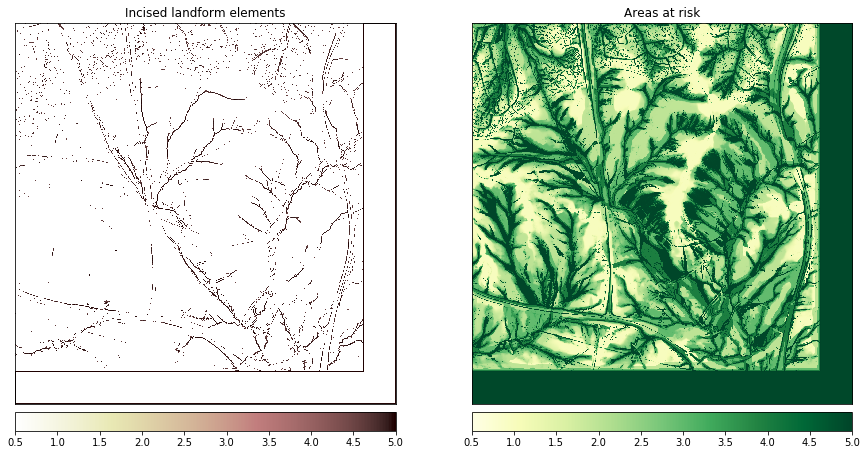

In [170]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(ILE_4, cmap="pink_r", vmin = 0.5, vmax = 5)
a.set_title('Incised landform elements')
plt.colorbar( orientation = 'horizontal', pad = 0.01)
plt.xticks([]);
plt.yticks([]);
b = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(areas_at_risk, cmap="YlGn", vmin = 0.5, vmax = 5)
b.set_title('Areas at risk')
plt.colorbar ( orientation = 'horizontal', pad = 0.01)
plt.xticks([]);
plt.yticks([]);

## Optional: Combine both grids into a single layer.

In [57]:
%%capture
scale_list = ['scales', 4.5, 3.5, 2.5, 1.5, 0.5]
base_component_proportions = np.array(scale_limit(1))
tolerance = np.divide(base_component_proportions, 2)
for i in range(2,6):
    component_proportion_L = np.array(scale_limit(i))
    test = ((base_component_proportions - component_proportion_L) > tolerance).any()
    if test:
        max_scale = (scale_list[i - 1])
        break
        
future_potential = np.copy(areas_at_risk)

if max_scale == 0.5:
    ILE_4[ILE_4 < 0.5] = 0
elif max_scale == 1.5:
    ILE_4[ILE_4 < 1.5] = 0
elif max_scale == 2.5:
    ILE_4[ILE_4 < 2.5] = 0
elif max_scale == 3.5:
    ILE_4[ILE_4 < 3.5] = 0
elif max_scale == 4.5:
    ILE_4[ILE_4 < 4.5] = 0

#############################################################################################
# This section just extracts values from ILE > 0.5 and then increases them by 3 so that
# it can be combined with future_extent using a maximum argument.
extract_ILEs = np.copy(ILE_4)
extract_ILEs[extract_ILEs < max_scale] = 0 
extract_ILEs[extract_ILEs >= max_scale] = 1
ILEs = np.multiply(extract_ILEs, (ILE_4 + 2))

#############################################################################################
combined_map = (np.maximum(ILEs, future_potential))


## Plot combined map. Values from 0-5 are areas at risk and >5 are incised landform elements.

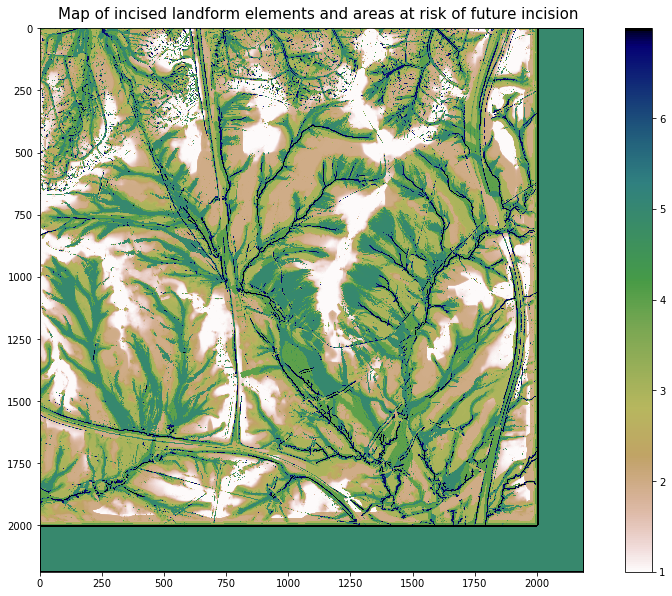

In [169]:
fig = plt.figure(figsize=(15,10))
#title = fig.set_title('Incised landform elements')
plt.imshow(combined_map, cmap="gist_earth_r")
fig.suptitle('Map of incised landform elements and areas at risk of future incision', y = 0.91, fontsize = 15)
plt.grid(False);
plt.colorbar();

## Write output to GeoTIFF.

In [84]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = np_array.shape[1]
    rows = np_array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = original_tiff.GetGeoTransform() 
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64": 
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster

In [85]:
np_array_to_Geotiff('incised_landform_elements.tif', input_geotiff, ILE_4, ILE_4.dtype)
np_array_to_Geotiff('areas_at_risk.tif', input_geotiff, areas_at_risk, areas_at_risk.dtype)
np_array_to_Geotiff('combined_map.tif', input_geotiff, combined_map, combined_map.dtype)

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
